In [15]:
import normflows as nf
from normflows import flows
## Standard libraries
import os
import math
import time
import numpy as np 

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as tdata
import torch.optim as optim

import dgl #NOTE: for dgl.batch and dgl.unbatch
from dgl import save_graphs, load_graphs
from dgl.data import DGLDataset
from dgl.dataloading import GraphDataLoader
from dgl.data.utils import save_info, load_info, Subset

import umap
reducer = umap.UMAP();
from tqdm import tqdm

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cuda:0


/tmp/ipykernel_973027/1941874460.py:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [2]:
#custom imports
from utils import load_graph_dataset, train, evaluate, GraphDataset, get_graph_dataset_info
from models import GIN, HeteroGIN

In [3]:
from numpy.random import default_rng
rng = default_rng()


In [4]:
'''                                              '''
'''     SETTING UP LATENT SPACE REPRESENTATION   '''
'''                                              '''

# Data and MC both have the same prefix
prefix = "/hpc/group/vossenlab/mfm45/.dgl/"

# MC inside Lambda_train_matched_jobs_outbending_cache_bg50nA_7_28_22__pT_phi_theta_beta_chi2_pid_status__Normalized
MCdataset = "Lambda_train_matched_jobs_outbending_cache_bg50nA_7_28_22__pT_phi_theta_beta_chi2_pid_status__Normalized"

# Data inside data_jobs_rga_fall2018_7_28_22__pT_phi_theta_beta_chi2_pid_status__Normalized
DATAdataset = "data_jobs_rga_fall2018_7_28_22__pT_phi_theta_beta_chi2_pid_status__Normalized"

max_events = 1e5
split = 0.1
nlayers = 2
nmlp = 3
hdim = 64
nclasses, nfeatures, nfeatures_edge = get_graph_dataset_info(dataset=MCdataset, prefix=prefix)
dropout = 0.8
learn_eps = False
batch = 256
indices = None
nworkers = 0
npooling = "max"
gpooling = "max"
torch.manual_seed(0)

#select model
extractor = GIN(nlayers, nmlp, nfeatures,
            hdim, nclasses, dropout, learn_eps, npooling, gpooling).to(device)
extractor.load_state_dict(torch.load("logs/model_weights",map_location=device))
#select training data

<All keys matched successfully>

In [16]:
class Latent_data:
    def __init__(self, in_tensor):
        self.data = in_tensor
        self.num_events = in_tensor.size()[0]
        self.latent_size = in_tensor.size()[1]
    def set_batch_size(self,batch_size):
        self.batch_size = batch_size
        self.max_iter = int(self.num_events / self.batch_size)
    def sample(self,iteration = 0, random = False):
        if(random):
            return self.sample_random()
        else:
            return self.sample_fixed(iteration)
    def sample_fixed(self,iteration):
        #0 index iterations - the "first" iteration is with iteration = 0
        # Calculate the first index we want to take from training data (rest of data is directly after)
        begin = iteration * self.batch_size
        # initialize
        samples = torch.zeros(self.batch_size, self.latent_size)
        #loop over consecutive tensors, save to return tensor
        for i in range(self.batch_size):
            samples[i] = self.data[begin + i]
        return samples
    def sample_random(self):
        indices = rng.integers(low=0, high=self.num_events, size=self.batch_size)
        samples = torch.zeros(self.batch_size,self.latent_size)
        for index in range(len(indices)):
            samples[index] = self.data[indices[index]]
        return samples

In [17]:
def create_latent_data(dataset_directory, extractor, prefix = "/hpc/group/vossenlab/mfm45/.dgl/", split = 0.8, max_events = 140000, num_samples = 250, mode = "default"):
    if(mode == "test"):
        data_range = range(int(split*max_events),max_events)
    elif(mode == "train"):
        data_range = range(0, int(split*max_events))
    elif(mode == "default"):
        print(f"No mode given, defaulting to training\n")
        data_range = range(0, int(split*max_events))
    else:
        raise Exception("Invalid mode: {mode}\nPlease use either \"train,\" or \"test\" ")
    
    dataset = GraphDataset(prefix+dataset_directory)
    dataset.load()
    dataset = Subset(dataset,data_range)
    dgl_batch = dgl.batch(dataset.dataset.graphs[dataset.indices.start:dataset.indices.stop])
    dgl_batch = dgl_batch.to(device)
    latent = extractor.get_latent_repr(dgl_batch).detach().cpu()
    latent_obj = Latent_data(latent)
    latent_obj.set_batch_size(num_samples)
    return latent_obj

In [8]:
training_data_DATA = create_latent_data(DATAdataset, extractor)
training_data_MC = create_latent_data(MCdataset, extractor)

testing_data_DATA = create_latent_data(DATAdataset, extractor, mode = "test")
testing_data_MC = create_latent_data(MCdataset, extractor, mode = "test")

No mode given, defaulting to training



/hpc/group/vossenlab/rck32/miniconda3/envs/venv/lib/python3.11/site-packages/dgl/backend/pytorch/tensor.py:449: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


No mode given, defaulting to training



In [18]:
# Assure that all the data is the correct size
assert((training_data_DATA.latent_size == testing_data_DATA.latent_size) and (training_data_MC.latent_size == testing_data_MC.latent_size) and (training_data_MC.latent_size == training_data_DATA.latent_size))

In [19]:
def get_masked_affine(num_layers = 32):
    #mask
    b = torch.ones(71)
    for i in range(b.size()[0]):
        if i % 2 == 0:
            b[i] = 0
    masked_affine_flows = []
    for i in range(num_layers):
        s = nf.nets.MLP([71, 142, 142, 71])
        t = nf.nets.MLP([71, 142, 142, 71])
        if i % 2 == 0:
            masked_affine_flows += [nf.flows.MaskedAffineFlow(b, t, s)]
        else:
            masked_affine_flows += [nf.flows.MaskedAffineFlow(1 - b, t, s)]
    return masked_affine_flows

In [20]:
# SETTING UP DATA MODEL

masked_affine_flows_train_DATA = get_masked_affine()
masked_affine_flows_test_DATA = get_masked_affine()
distribution_DATA = nf.distributions.DiagGaussian(training_data_DATA.latent_size, trainable = False)
masked_affine_model_DATA = nf.NormalizingFlow(q0=distribution_DATA, flows=masked_affine_flows_train_DATA)
DATA_model = masked_affine_model_DATA.to(device)

In [21]:
# SETTING UP MC MODEL

masked_affine_flows_train_MC = get_masked_affine()
masked_affine_flows_test_MC = get_masked_affine()
distribution_MC = nf.distributions.DiagGaussian(training_data_MC.latent_size, trainable = False)
masked_affine_model_MC = nf.NormalizingFlow(q0=distribution_MC, flows=masked_affine_flows_train_MC)
MC_model = masked_affine_model_MC.to(device)

In [22]:
# train the MC model
MC_model.train()
loss_hist_MC = np.array([])
optimizer = torch.optim.Adam(MC_model.parameters(), lr=5e-4, weight_decay=1e-5)
with tqdm(total=training_data_MC.max_iter, position=0, leave=True) as pbar:
    for it in tqdm(range(training_data_MC.max_iter), position = 0, leave=True):
        optimizer.zero_grad()
        #randomly sample the latent space
        samples = training_data_MC.sample(iteration = it)
        samples = samples.to(device)
        loss = MC_model.forward_kld(samples)
        # Do backprop and optimizer step
        if ~(torch.isnan(loss) | torch.isinf(loss)):
            loss.backward()
            optimizer.step()
        # Log loss
        if~(torch.isnan(loss)):
            loss_hist_MC = np.append(loss_hist_MC, loss.to('cpu').data.numpy())

  0%|          | 0/448 [00:41<?, ?it/s]


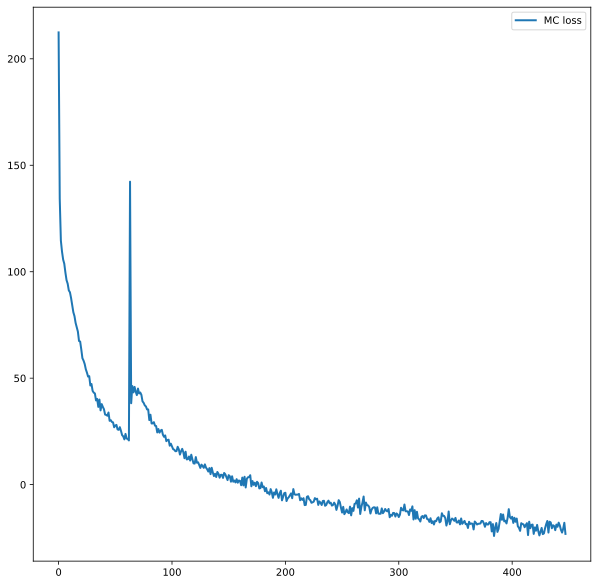

In [23]:
fig = plt.figure(figsize=(10, 10))
plt.plot(loss_hist_MC, label='MC loss')
plt.legend()
plt.show()
# fig.savefig("loss_masked_affine.jpeg")

In [24]:
loss_hist_MC.min()

-24.11078643798828

In [25]:
# TRAINING DATA
# train the DATA model
DATA_model.train()
loss_hist_DATA = np.array([])
optimizer = torch.optim.Adam(DATA_model.parameters(), lr=5e-4, weight_decay=1e-5)
with tqdm(total=training_data_DATA.max_iter, position=0, leave=True) as pbar:
    for it in tqdm(range(training_data_DATA.max_iter), position = 0, leave=True):
        optimizer.zero_grad()
        #randomly sample the latent space
        samples = training_data_DATA.sample(iteration = it)
        samples = samples.to(device)
        loss = DATA_model.forward_kld(samples)
        # Do backprop and optimizer step
        if ~(torch.isnan(loss) | torch.isinf(loss)):
            loss.backward()
            optimizer.step()
        # Log loss
        if~(torch.isnan(loss)):
            loss_hist_DATA = np.append(loss_hist_DATA, loss.to('cpu').data.numpy())

  0%|          | 0/448 [00:43<?, ?it/s]


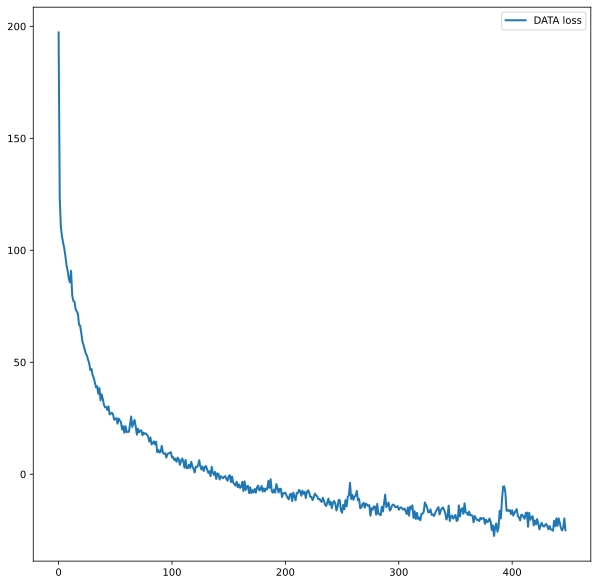

In [26]:
fig = plt.figure(figsize=(10, 10))
plt.plot(loss_hist_DATA, label='DATA loss')
plt.legend()
plt.show()
# fig.savefig("loss_masked_affine.jpeg")

# Testing MC and DATA models

In [27]:
#Testing dataset for DATA: testing_data_DATA
#Testing dataset for MC: testing_data_MC

In [28]:
# Testing MC

torch.manual_seed(42)
MC_model.eval()
test_loss_MC = 0
counted_batches_MC = 0

DATA_model.eval()
test_loss_DATA = 0
counted_batches_DATA = 0
with torch.no_grad():
    for it in tqdm(range(testing_data_MC.max_iter), position = 0, leave=True):
        #MC section
        test_samples_MC = testing_data_MC.sample(iteration = it)
        test_samples_MC = test_samples_MC.to(device)
        new_loss_MC = MC_model.forward_kld(test_samples_MC)
        if(not math.isnan(new_loss_MC)):
            test_loss_MC += new_loss_MC
            counted_batches_MC += 1
        
        #DATA section
        test_samples_DATA = testing_data_DATA.sample(iteration = it)
        test_samples_DATA = test_samples_DATA.to(device)
        new_loss_DATA = DATA_model.forward_kld(test_samples_DATA)
        if(not math.isnan(new_loss_DATA)):
            test_loss_DATA += new_loss_DATA
            counted_batches_DATA += 1
        
    print(f"average loss MC: {test_loss_MC/counted_batches_MC}")
    print(f"average loss DATA: {test_loss_DATA/counted_batches_DATA}")

100%|██████████| 112/112 [00:04<00:00, 24.08it/s]

average loss MC: -11.298376083374023
average loss DATA: -24.49144172668457


# Plotting sanity checks

In [29]:
# Converting MC to gaussian
transformed_latent_MC = torch.zeros_like(testing_data_MC.data)
MC_model.eval()
with torch.no_grad():
    for it in tqdm(range(testing_data_MC.max_iter), position = 0, leave=True):
        test_samples = testing_data_MC.sample(iteration = it)
        test_samples = test_samples.to(device)
        output_batch = MC_model.inverse(test_samples)
        for i in range(testing_data_MC.batch_size):
            transformed_latent_MC[it*testing_data_MC.batch_size + i] = output_batch[i]

100%|██████████| 112/112 [00:02<00:00, 40.60it/s]


In [30]:
# DATA 1D plots
transformed_latent_DATA = torch.zeros_like(testing_data_DATA.data)
normalized_DATA_batches = torch.zeros(testing_data_DATA.max_iter,testing_data_DATA.batch_size,testing_data_DATA.latent_size).to(device)
MC_model.eval()
with torch.no_grad():
    for it in tqdm(range(testing_data_DATA.max_iter), position = 0, leave=True):
        test_samples = testing_data_DATA.sample(iteration = it)
        test_samples = test_samples.to(device)
        output_batch = DATA_model.inverse(test_samples)
        normalized_DATA_batches[it] = output_batch
        for i in range(testing_data_DATA.batch_size):
            transformed_latent_DATA[it*testing_data_DATA.batch_size + i] = output_batch[i]

100%|██████████| 112/112 [00:02<00:00, 40.57it/s]


## MC Transformed Histograms

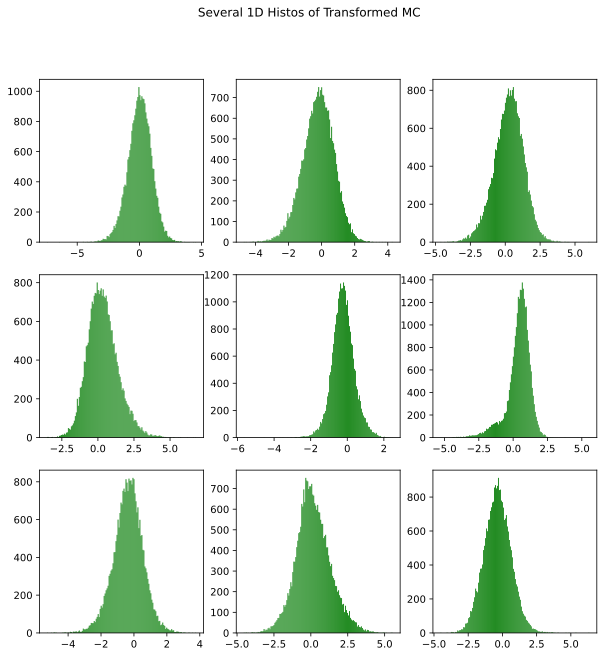

In [31]:
MC_histos, ((mh11,mh12,mh13),(mh21,mh22,mh23),(mh31,mh32,mh33)) = plt.subplots(3,3, figsize = (10,10))
MC_histos.suptitle("Several 1D Histos of Transformed MC")
mhlist = [mh11,mh12,mh13,mh21,mh22,mh23,mh31,mh32,mh33]
for i in range(len(mhlist)):
    mhlist[i].hist(transformed_latent_MC[:,i], bins=150,color="forestgreen");
plt.show()

## Transformed DATA Histos

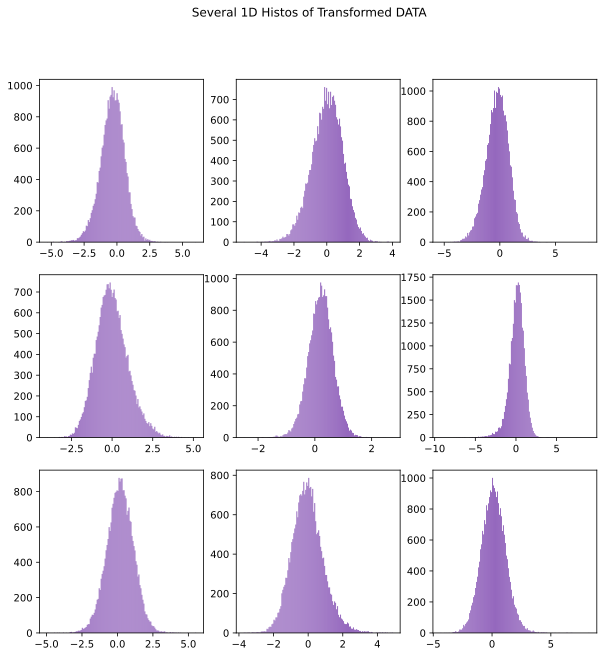

In [32]:
DATA_histos, ((dh11,dh12,dh13),(dh21,dh22,dh23),(dh31,dh32,dh33)) = plt.subplots(3,3, figsize = (10,10))
DATA_histos.suptitle("Several 1D Histos of Transformed DATA")
dhlist = [dh11,dh12,dh13,dh21,dh22,dh23,dh31,dh32,dh33]
for i in range(len(dhlist)):
    dhlist[i].hist(transformed_latent_DATA[:,i], bins=150,color="tab:purple");
plt.show()

## MC Original Latent Space Histograms

In [ ]:
MC_histos_latent, ((mlh11,mlh12,mlh13),(mlh21,mlh22,mlh23),(mlh31,mlh32,mlh33)) = plt.subplots(3,3, figsize = (10,10))
MC_histos_latent.suptitle("Several 1D Histos of Latent MC")
mlhlist = [mlh11,mlh12,mlh13,mlh21,mlh22,mlh23,mlh31,mlh32,mlh33]
for i in range(len(mlhlist)):
    mlhlist[i].hist(testing_data_MC.data[:,i], bins=150,color="royalblue");
plt.show()

In [ ]:
DATA_histos_latent, ((dlh11,dlh12,dlh13),(dlh21,dlh22,dlh23),(dlh31,dlh32,dlh33)) = plt.subplots(3,3, figsize = (10,10))
DATA_histos_latent.suptitle("Several 1D Histos of Latent DATA")
dlhlist = [dlh11,dlh12,dlh13,dlh21,dlh22,dlh23,dlh31,dlh32,dlh33]
for i in range(len(dlhlist)):
    dlhlist[i].hist(testing_data_DATA.data[:,i], bins=150,color="red");
plt.show()

# UMAP
## Plotting Latent Space after transform (should be gaussian)

In [ ]:
# plt.rc('font', size=10) #controls default text size                                                                                                                     
# plt.rc('axes', titlesize=25) #fontsize of the title                                                                                                                     
# plt.rc('axes', labelsize=25) #fontsize of the x and y labels                                                                                                            
# plt.rc('xtick', labelsize=20) #fontsize of the x tick labels                                                                                                            
# plt.rc('ytick', labelsize=20) #fontsize of the y tick labels                                                                                                            
# plt.rc('legend', fontsize=15) #fontsize of the legend
figsize = (8,5) #NOTE: ADDED 9/30/22
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

### Plots together using subplots

In [ ]:
transformed_DATA = reducer.fit_transform(transformed_latent_DATA)
transformed_MC = reducer.fit_transform(transformed_latent_MC)

In [ ]:
#Plotting both Latent Spaces using subplots
fig, (ax11, ax12) = plt.subplots(1,2, figsize = (16,5))
fig.suptitle("Transformed projection with UMAP")
ax11.plot(transformed_MC[:,0],transformed_MC[:,1],'o',markersize=2,color = "forestgreen")
ax11.set_title('MC')
ax12.plot(transformed_DATA[:,0],transformed_DATA[:,1],'o',markersize=2,color="tab:purple")
ax12.set_title('DATA')
plt.show()

#### Overlaying transformed plots

In [ ]:
fig4, ax3 = plt.subplots()
ax4 = ax3.twinx()
fig4.suptitle("UMAP Projection of transformed MC and DATA")
ax3.plot(transformed_MC[:,0],transformed_MC[:,1],'o',markersize=2, alpha=0.1,c='g', label = 'MC')
ax4.plot(transformed_DATA[:,0],transformed_DATA[:,1],'o',markersize=2,alpha=0.1,c='m', label = 'DATA')
leg = fig4.legend(title = "Key")
for lh in leg.legend_handles:
    lh.set_alpha(1)
plt.show()

## Latent space UMAP plots
##### Original datasets

In [ ]:
latent_DATA = reducer.fit_transform(testing_data_DATA.data)
latent_MC = reducer.fit_transform(testing_data_MC.data)

In [ ]:
#Plotting both Latent Spaces using subplots
fig2, (ax21, ax22) = plt.subplots(1,2, figsize = (16,5))
fig2.suptitle("Latent space projection with UMAP")
ax21.plot(latent_MC[:,0],latent_MC[:,1],'o',markersize=2,color="royalblue")
ax21.set_title('latent MC')
ax22.plot(latent_DATA[:,0],latent_DATA[:,1],'o',markersize=2,color='red')
ax22.set_title('latent DATA')

plt.show()

In [ ]:
fig3, ax1 = plt.subplots()
fig3.suptitle("UMAP Projection of Latent Representation")
ax2 = ax1.twinx()
ax1.plot(latent_MC[:,0],latent_MC[:,1],'o',markersize=2, alpha=0.1,c='b',label= "MC");
ax2.plot(latent_DATA[:,0],latent_DATA[:,1],'o',markersize=2,alpha=0.1,c='r',label="DATA");
leg = fig3.legend(title = "Key")
for lh in leg.legend_handles:
    lh.set_alpha(1)
plt.show()

### Comparing MC and DATA, both transformed with MC Flow

In [ ]:
# Converting MC to gaussian
transformed_latent_DATA_MCFlow = torch.zeros_like(testing_data_DATA.data)
MC_model.eval()
with torch.no_grad():
    for it in tqdm(range(testing_data_DATA.max_iter), position = 0, leave=True):
        test_samples = testing_data_DATA.sample(iteration = it)
        test_samples = test_samples.to(device)
        output_batch = MC_model.inverse(test_samples)
        for i in range(testing_data_MC.batch_size):
            transformed_latent_DATA_MCFlow[it*testing_data_DATA.batch_size + i] = output_batch[i]

In [ ]:
transformed_DATA_MCFlow = reducer.fit_transform(transformed_latent_DATA_MCFlow)

In [ ]:
fig5, ax5 = plt.subplots()
ax6 = ax5.twinx()
fig5.suptitle("UMAP Projection of transformed MC and DATA both using MCFlow")
ax5.plot(transformed_MC[:,0],transformed_MC[:,1],'o',markersize=2, alpha=0.1,c='g', label = 'MC');
ax6.plot(transformed_DATA_MCFlow[:,0],transformed_DATA_MCFlow[:,1],'o',markersize=2,alpha=0.1,c='cyan', label = 'DATA_MCFlow');
leg = fig5.legend(title = "Key")
for lh in leg.legend_handles:
    lh.set_alpha(1)
plt.show()

In [ ]:
fig6, ax7 = plt.subplots()
ax8 = ax7.twinx()
fig6.suptitle("UMAP Projection of transformed DATA, different models")
ax7.plot(transformed_DATA[:,0],transformed_DATA[:,1],'o',markersize=2, alpha=0.1,c='m', label = 'DATA');
ax8.plot(transformed_DATA_MCFlow[:,0],transformed_DATA_MCFlow[:,1],'o',markersize=2,alpha=0.1,c='cyan', label = 'DATA_MCFlow');
leg = fig6.legend(title = "Key")
for lh in leg.legend_handles:
    lh.set_alpha(1)
plt.show()

# Transforming DATA to MC

In [ ]:
# From above plotting: <transformed_latent_DATA> is the tensor with normalized DATA
# Now need to transform it back to MC version of latent space

In [ ]:
'''
Forward run
    -input: gauss version of DATA
    -output: latent space
'''
# to hold the batches
latent_batches = torch.empty_like(normalized_DATA_batches).to(device)
# to hold the output unbatched
transformed_latent = torch.empty_like(testing_data_DATA.data).to(device)
MC_model.eval()
counted_batches = 0
with torch.no_grad():
    for it in tqdm(range(testing_data_DATA.max_iter), position = 0, leave=True):
        latent_batches[it] = MC_model.forward(normalized_DATA_batches[it])
        for i in range(testing_data_DATA.batch_size):
            transformed_latent[it*testing_data_DATA.batch_size + i] = latent_batches[it][i]
transformed_latent = transformed_latent.detach().to("cpu")

In [ ]:
#Create UMAP projections
full_pass_DATA = reducer.fit_transform(transformed_latent)

In [ ]:
#Plotting original MC and full pass DATA
fig8, (ax81, ax82) = plt.subplots(1,2, figsize = (16,5))
fig8.suptitle("Latent space projection with UMAP")
ax81.plot(latent_MC[:,0],latent_MC[:,1],'o',markersize=2,color="olive")
ax81.set_title('original MC')
ax82.plot(full_pass_DATA[:,0],full_pass_DATA[:,1],'o',markersize=2,color='orchid')
ax82.set_title('full pass DATA')

plt.show()

In [ ]:
#Plotting DATA transformed to MC vs true MC
fig7, ax9 = plt.subplots()
ax10 = ax9.twinx()
fig7.suptitle("UMAP Projection of transformed DATA and true MC")
ax9.plot(latent_MC[:,0],latent_MC[:,1],'o',markersize=2, alpha=0.1,c='g', label = 'original MC')
ax10.plot(full_pass_DATA[:,0],full_pass_DATA[:,1],'o',markersize=2,alpha=0.1,c='m', label = 'full pass DATA')
leg = fig7.legend(title = "Key")
for lh in leg.legend_handles:
    lh.set_alpha(1)
plt.show()

In [ ]:
transformed_latent = torch.zeros_like(test_latent_repr)

In [ ]:
output_batches = torch.empty(max_iter_test,num_samples,testing_data.latent_size)

In [ ]:
# Closure Test - run inverse() then forward()

'''
Inverse run
    -input: latent_repr
    -output: gaussian version
'''
torch.manual_seed(42)
model.eval()
num_samples = 500
counted_batches = 0
with torch.no_grad():
    for it in tqdm(range(max_iter_test), position = 0, leave=True):
        test_samples = testing_data.sample(iteration = it)
        test_samples = test_samples.to(device)
        output_batches[it] = model.inverse(test_samples)
        #for i in range(num_samples):
        #    transformed_latent[it*num_samples + i] = output_batch[i]
output_batches = output_batches.to(device)

In [ ]:
'''
Forward run
    -input: gauss version
    -output: latent space
'''
final_output = torch.empty(output_batches.size()[1],output_batches.size()[2])
transformed_latent = torch.zeros_like(test_latent_repr)
model.eval()
counted_batches = 0
with torch.no_grad():
    for it in tqdm(range(max_iter_test), position = 0, leave=True):
        final_output = model.forward(output_batches[it])
        for i in range(num_samples):
            transformed_latent[it*num_samples + i] = final_output[i]

In [ ]:
diff = transformed_latent - test_latent_repr
print(f"max difference: {diff.max()}\naverage difference: {diff.sum() / np.prod(transformed_latent.size())}")

In [ ]:
print(f"average error: {100*(diff.sum() / np.prod(transformed_latent.size()))/(transformed_latent.sum() / np.prod(transformed_latent.size()))}%")

Max diff: tensor(1.2398e-05)

average diff: tensor(1.2707e-07) | tensor(1.3718e-07)